In [265]:
import yaml
cfg = None
with open('../config.yaml', 'r') as config:
    cfg = yaml.safe_load(config)

In [266]:
import pandas as pd
import numpy as np
from numpy.typing import NDArray
from matplotlib import pyplot as plt
import seaborn as sns
import json
import os
from PIL import Image
import random
import cv2

In [267]:
from sklearn.model_selection import train_test_split
import numpy as np
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from glob import glob
from sklearn.base import BaseEstimator, TransformerMixin

In [268]:
def display_sample_images(data, classes, n=3):
    fig, axes = plt.subplots(len(classes), n, figsize=(12, 8))
    
    for i, class_name in enumerate(classes):
        class_images = random.sample(data['Train'][class_name], n)
        
        for j in range(n):
            ax = axes[i, j] if len(classes) > 1 else axes[j]
            ax.imshow(class_images[j].squeeze(), cmap='gray')
            ax.set_title(f"{class_name} {j+1}")
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()

def process_image(filename: str, size=(128, 128)):
    with Image.open(filename) as img:
        img = img.convert('L').resize(size)
        
        arr = np.array(img, dtype=np.uint8)[..., np.newaxis]
        return arr

def load_data(path: str, classes: list[str], data_size: float = 1.0, test_size: float = 0.2, random_state: int = 42):
    images = dict.fromkeys(["Train", "Test"], [dict.fromkeys(classes), dict.fromkeys(classes)])
    for t in ["Train", "Test"]:
        images[t] = dict.fromkeys(classes)
    
    for c in classes:
        image_names = os.listdir(os.path.join(path, c))
        for i, image in enumerate(image_names):
            image_names[i] = os.path.join(path, c, image)
        if data_size == 1.0: X = image_names
        else: X, _ = train_test_split(image_names, train_size=data_size, random_state=random_state)
        X_train, X_test = train_test_split(X, test_size=test_size, random_state=random_state)
        images['Train'][c] = [process_image(x) for x in X_train]
        images['Test'][c] = [process_image(x) for x in X_test]
        
    display_sample_images(images, classes)
    
    X_train = []
    X_test = []
    y_train = []
    y_test = []
    decoder = dict.fromkeys(classes)
    
    for idx, c in enumerate(classes):
        X_train += images['Train'][c]
        y_train += [idx] * len(images['Train'][c])
        X_test += images['Test'][c]
        y_test += [idx] * len(images['Test'][c])
        decoder[c] = idx
        
    return X_train, y_train, X_test, y_test, decoder

/home/victor/anaconda3/envs/statistic/lib/python3.13/site-packages/PIL/TiffImagePlugin.py:935: UserWarning: Truncated File Read
  warnings.warn(str(msg))


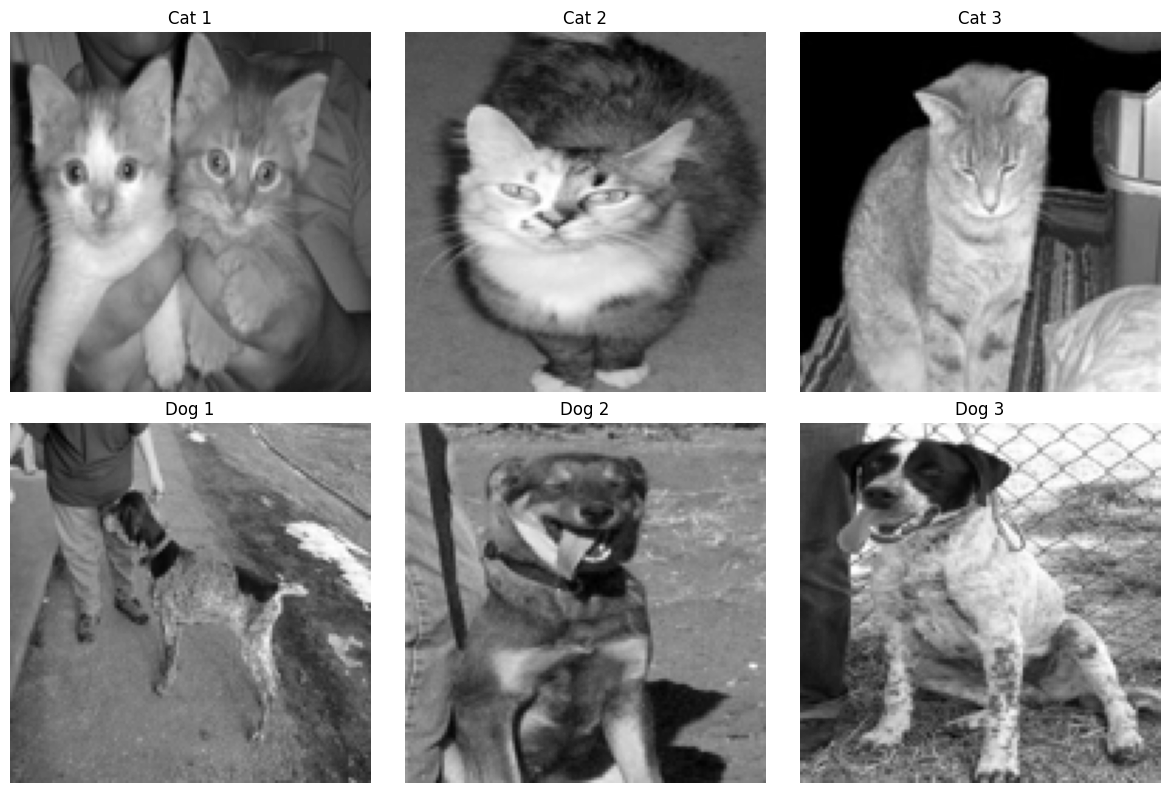

In [269]:
classes = ['Cat', 'Dog']
X_train, y_train, X_test, y_test, decoder = load_data(cfg["dataset_2"], classes, data_size=1.0)

Для дальнейшей работы необходимо как-то преобразовать двумерные массивы в одномерные. Для этого можно применить операцию векторизации. Однако, есть более эффективный метод, который состоит в том, чтобы использовать алгоритм Bag of Visual Words

In [270]:
class BoVW(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=100):
        self.extractor = cv2.SIFT_create()
        self.n_clusters = n_clusters
        self.kmeans = None

    def fit(self, images, y=None):
        descriptors_list = self._extract_descriptors(images)
        all_descriptors = np.vstack(descriptors_list)
        self.kmeans = MiniBatchKMeans(n_clusters=self.n_clusters, random_state=42)
        self.kmeans.fit(all_descriptors)
        return self

    def transform(self, images):
        histograms = []
        for img in images:
            keypoints, descriptors = self.extractor.detectAndCompute(img, None)
            if descriptors is not None:
                labels = self.kmeans.predict(descriptors)
                hist, _ = np.histogram(labels, bins=np.arange(self.n_clusters + 1))
            else:
                hist = np.zeros(self.n_clusters)
            histograms.append(hist)
        return np.array(histograms)

    def _extract_descriptors(self, images):
        descriptors_list = []
        for img in images:
            keypoints, descriptors = self.extractor.detectAndCompute(img, None)
            if descriptors is not None:
                descriptors_list.append(descriptors)
        return descriptors_list


In [271]:
bovw = BoVW(n_clusters=100)
X_train = bovw.fit_transform(X_train)
X_test = bovw.transform(X_test)

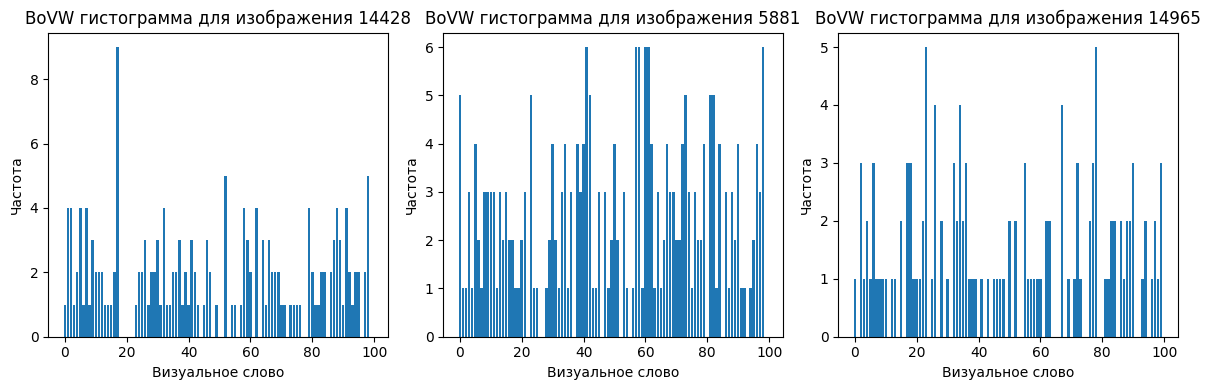

In [ ]:
num_samples = 3
indices = random.sample(range(len(X_train)), num_samples)

fig, axes = plt.subplots(1, num_samples, figsize=(12, 4))

for i, idx in enumerate(indices):
    axes[i].bar(range(bovw.n_clusters), X_train[idx])
    axes[i].set_title(f'BoVW гистограмма для изображения {idx}')
    axes[i].set_xlabel('Визуальное слово')
    axes[i].set_ylabel('Частота')

plt.tight_layout()
plt.show()


In [273]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

models = {
    "svm": LinearSVC().fit(X_train, y_train),
    "knn": KNeighborsClassifier(n_neighbors=50).fit(X_train, y_train),
    "desision_tree":  DecisionTreeClassifier(max_depth=5, min_samples_leaf=8).fit(X_train, y_train),
    "boosting": HistGradientBoostingClassifier(max_depth=3, min_samples_leaf=8).fit(X_train, y_train),
    "linear": LogisticRegression().fit(X_train, y_train)
}

In [275]:
results = {
    "Train score": [],
    "Test score": []
}

for model in models.values():
    results["Train score"].append(model.score(X_train, y_train))
    results["Test score"].append(model.score(X_test, y_test))
    
results = pd.DataFrame(results, index=models.keys())

results

,Train score,Test score
svm,0.666067,0.6720
knn,0.641264,0.6202
desision_tree,0.619512,0.6082
boosting,0.694369,0.6644
linear,0.666167,0.6734


**Примения PCA**

In [276]:
from sklearn.decomposition import PCA

num_components_list = np.linspace(5, 100, 20).astype(int)
pca_results = dict.fromkeys(num_components_list)

for num_components in num_components_list:
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    models = {
        "svm": LinearSVC().fit(X_train_pca, y_train),
        "knn": KNeighborsClassifier(n_neighbors=50).fit(X_train_pca, y_train),
        "desision_tree":  DecisionTreeClassifier(max_depth=5, min_samples_leaf=8).fit(X_train_pca, y_train),
        "boosting": HistGradientBoostingClassifier(max_depth=3, min_samples_leaf=8).fit(X_train_pca, y_train),
        "linear": LogisticRegression().fit(X_train_pca, y_train)
    }
    pca_results[num_components] = []
    for model in models.values():
        pca_results[num_components].append(model.score(X_test_pca, y_test))
        
pca_results = pd.DataFrame(pca_results, index=models.keys())
pca_results

,5,10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100
svm,0.5902,0.6240,0.6478,0.6514,0.6542,0.6570,0.6578,0.6588,0.6584,0.6580,0.6590,0.6612,0.6632,0.6620,0.6630,0.6670,0.6670,0.6692,0.6720,0.6720
knn,0.6022,0.6482,0.6544,0.6576,0.6486,0.6496,0.6502,0.6426,0.6426,0.6460,0.6414,0.6412,0.6388,0.6382,0.6376,0.6386,0.6348,0.6260,0.6258,0.6202
desision_tree,0.5988,0.6258,0.6242,0.6214,0.6214,0.6214,0.6230,0.6230,0.6230,0.6222,0.6222,0.6222,0.6222,0.6222,0.6222,0.6222,0.6224,0.6224,0.6224,0.6224
boosting,0.6012,0.6474,0.6662,0.6670,0.6630,0.6648,0.6640,0.6658,0.6616,0.6650,0.6616,0.6628,0.6606,0.6588,0.6634,0.6624,0.6646,0.6644,0.6674,0.6694
linear,0.5908,0.6252,0.6478,0.6516,0.6538,0.6558,0.6580,0.6578,0.6582,0.6588,0.6588,0.6612,0.6636,0.6634,0.6628,0.6650,0.6664,0.6658,0.6720,0.6732


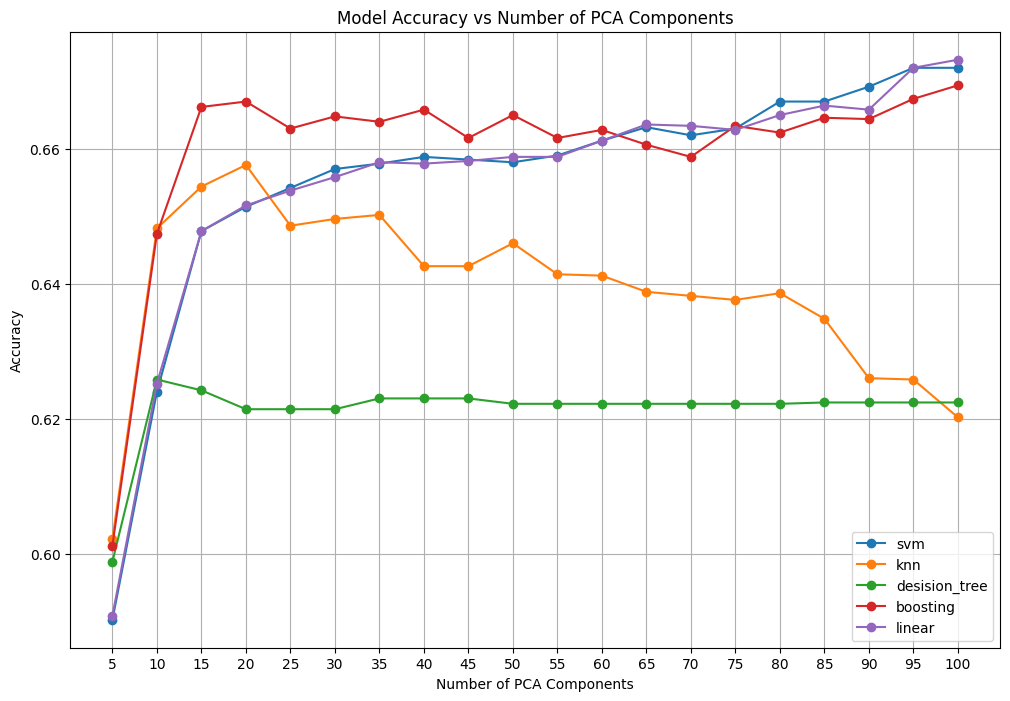

In [277]:
plt.figure(figsize=(12, 8))

for model_name in pca_results.index:
    plt.plot(pca_results.columns, pca_results.loc[model_name], 
             marker='o', label=model_name)

plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.xticks(pca_results.columns)
plt.show()

**Интересный замеченный момент**

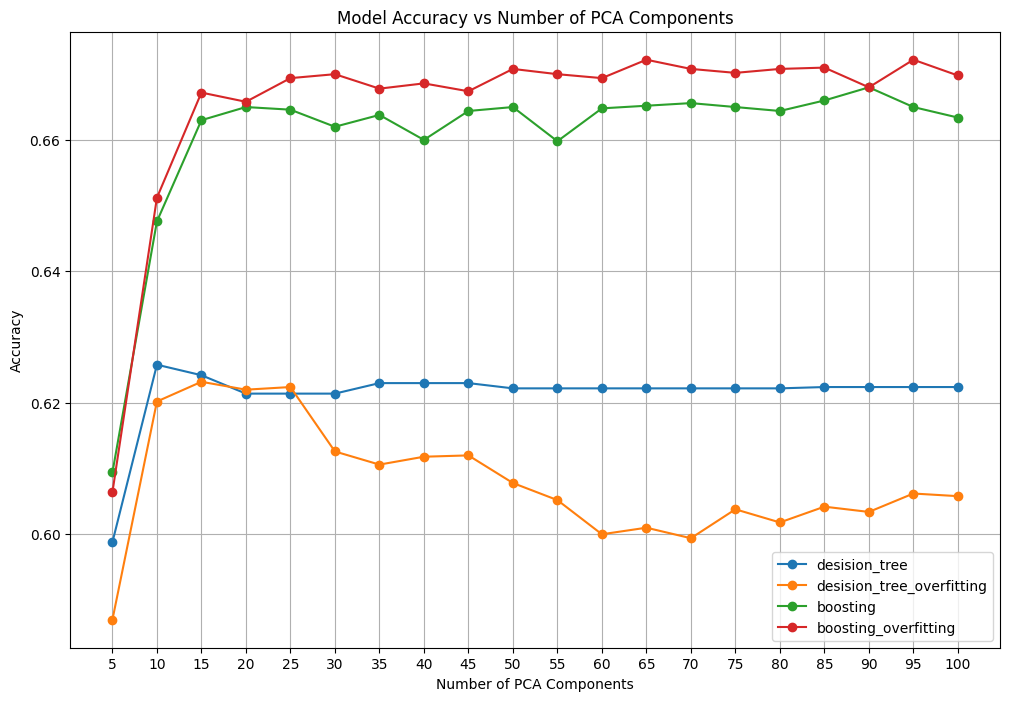

In [283]:
num_components_list = np.linspace(5, 100, 20).astype(int)
pca_results = dict.fromkeys(num_components_list)

for num_components in num_components_list:
    pca = PCA(n_components=num_components)
    X_train_pca = pca.fit_transform(X_train)
    X_test_pca = pca.transform(X_test)
    models = {
        "desision_tree":  DecisionTreeClassifier(max_depth=5, min_samples_leaf=8).fit(X_train_pca, y_train),
        "desision_tree_overfitting":  DecisionTreeClassifier(max_depth=10, min_samples_leaf=32).fit(X_train_pca, y_train),
        "boosting": HistGradientBoostingClassifier(max_depth=3, min_samples_leaf=8).fit(X_train_pca, y_train),
        "boosting_overfitting": HistGradientBoostingClassifier(max_depth=10, min_samples_leaf=32).fit(X_train_pca, y_train),
    }
    pca_results[num_components] = []
    for model in models.values():
        pca_results[num_components].append(model.score(X_test_pca, y_test))
        
pca_results = pd.DataFrame(pca_results, index=models.keys())

plt.figure(figsize=(12, 8))

for model_name in pca_results.index:
    plt.plot(pca_results.columns, pca_results.loc[model_name], 
             marker='o', label=model_name)

plt.xlabel('Number of PCA Components')
plt.ylabel('Accuracy')
plt.title('Model Accuracy vs Number of PCA Components')
plt.legend()
plt.grid(True)
plt.xticks(pca_results.columns)
plt.show()

**Вывод:** В некоторых случаях увеличение числа компонент может только навредить

<Axes: >

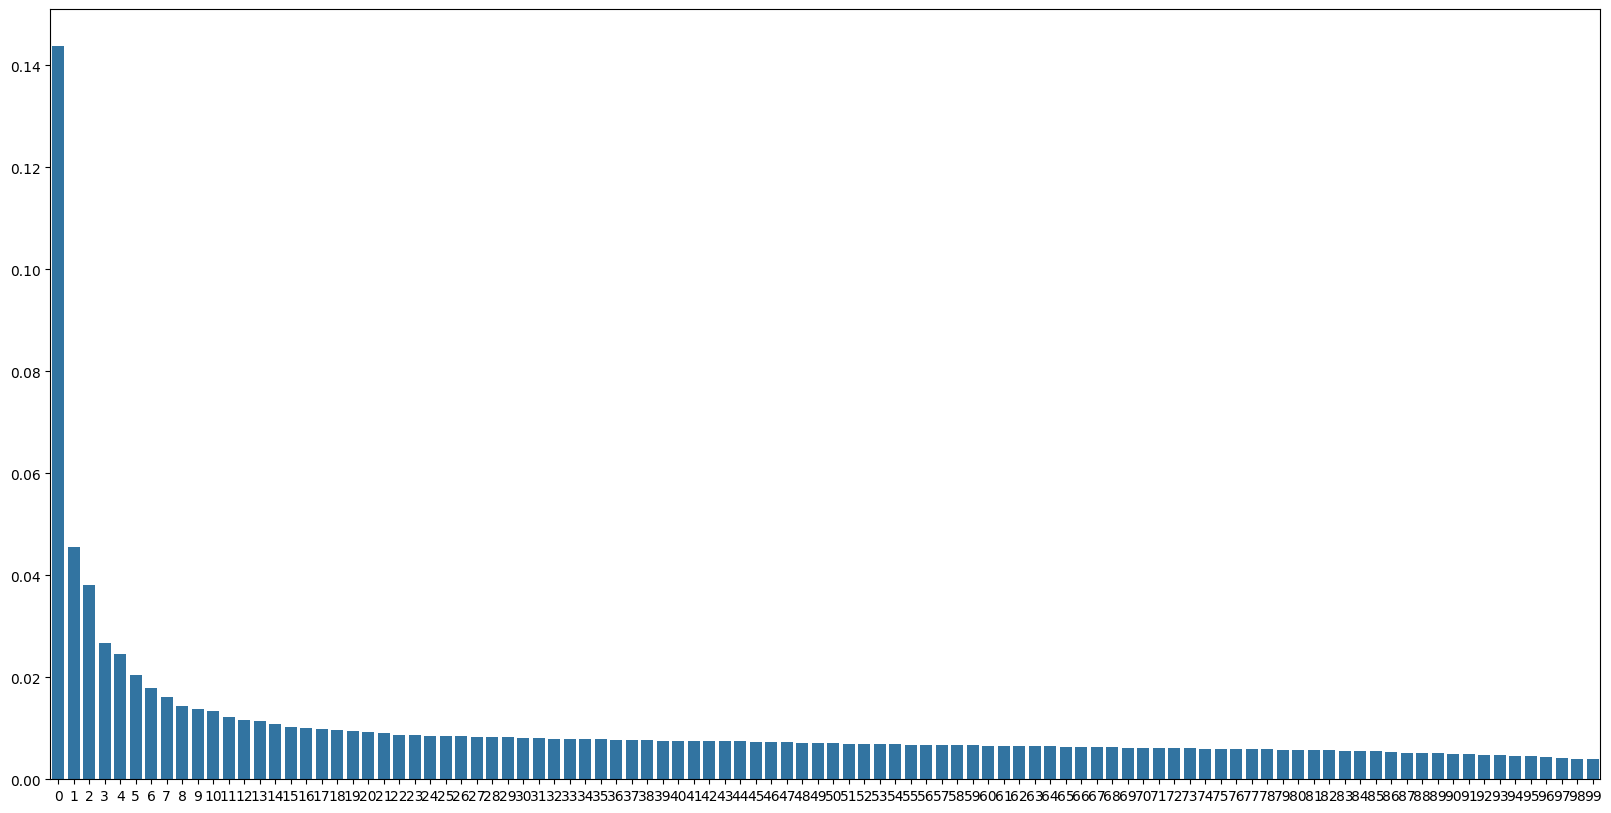

In [279]:
plt.figure(figsize=(20, 10))
sns.barplot(pca.explained_variance_ratio_)

In [280]:
pca = PCA().fit(X_train)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)
n_components_90 = np.argmax(cumulative_variance >= 0.9) + 1
print(f"Число компонент для 90% дисперсии: {n_components_90}")

Число компонент для 90% дисперсии: 80


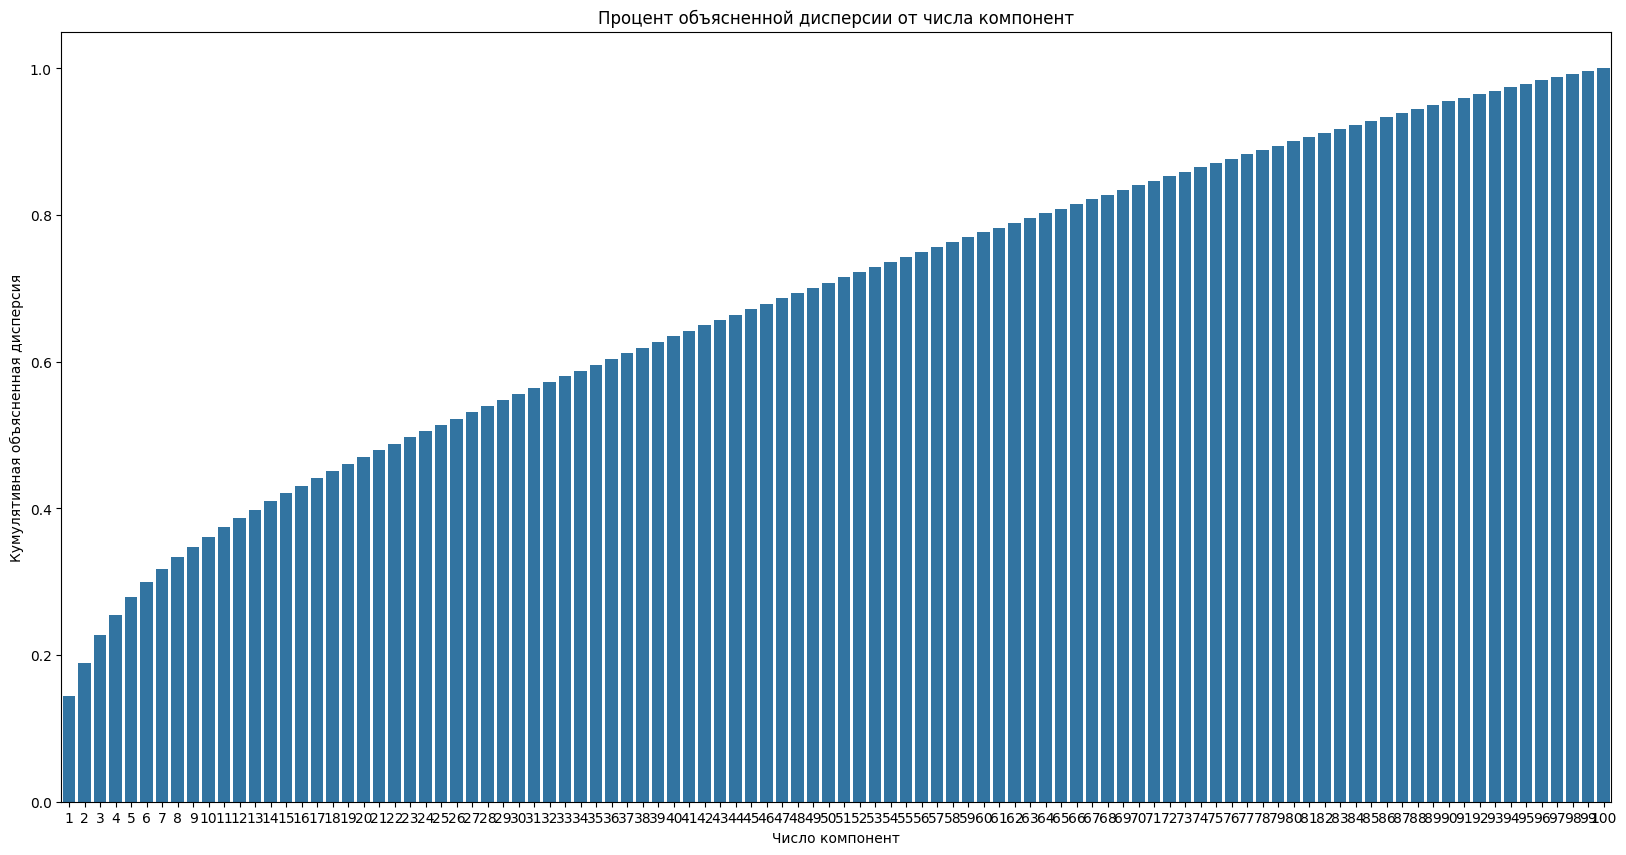

In [281]:
plt.figure(figsize=(20, 10))
sns.barplot(x=np.arange(1, len(cumulative_variance) + 1), y=cumulative_variance)
plt.title("Процент объясненной дисперсии от числа компонент")
plt.xlabel("Число компонент")
plt.ylabel("Кумулятивная объясненная дисперсия")
plt.show()

**Наилучшее точность была получена при `n_components = 100`, однако, почти такое-же было получено при `n_components = 15` => отрисуем при втором значении**

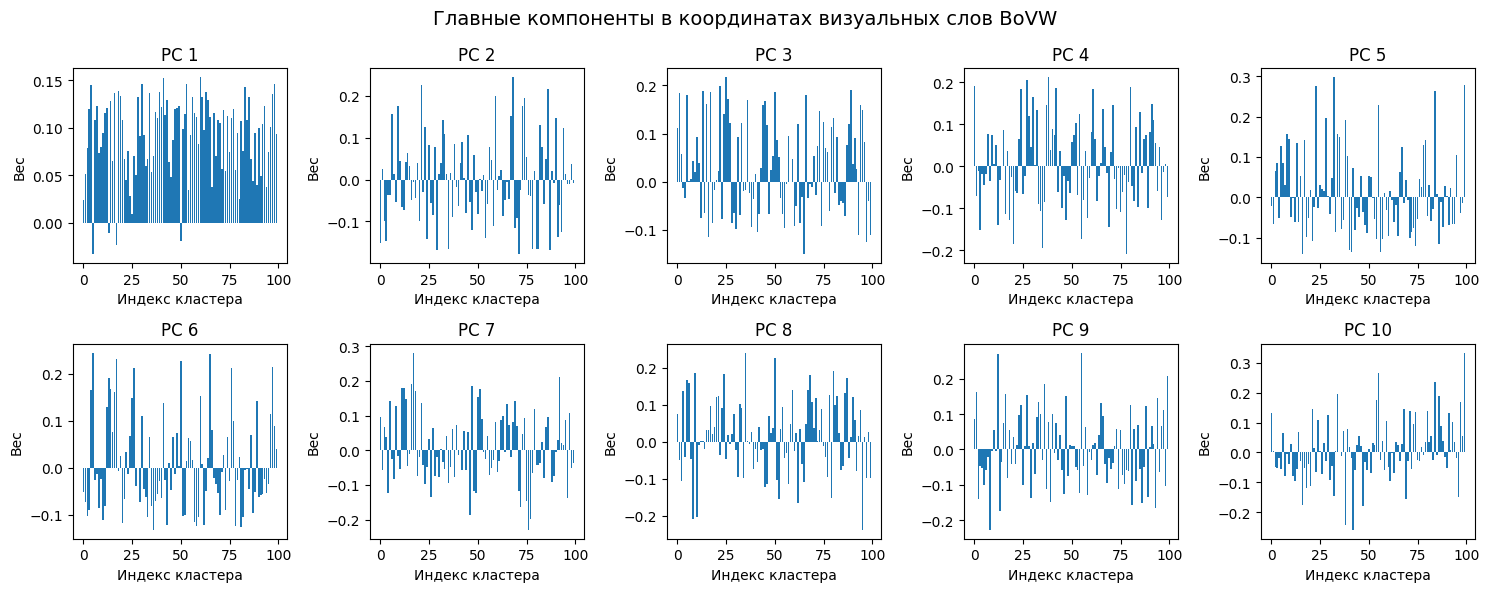

In [306]:
n_components = 15
pca_best = PCA(n_components=n_components)
pca_best.fit(X_train)
components = pca_best.components_[:n_components]

fig, axes = plt.subplots(2, 5, figsize=(15, 6))
fig.suptitle("Главные компоненты в координатах визуальных слов BoVW", fontsize=14)

for i, ax in enumerate(axes.flat):
    if i < n_components:
        ax.bar(range(len(components[i])), components[i])
        ax.set_title(f"PC {i+1}")
        ax.set_xlabel("Индекс кластера")
        ax.set_ylabel("Вес")
    else:
        ax.axis('off')

plt.tight_layout()
plt.show()